In [47]:
import os
import re
import matplotlib.pyplot as plt
import torch
import numpy as np

# Loss Curve

In [3]:
# Read Data from log file
def parse_log(log_file_path):
    losses = []
    with open(log_file_path, 'r') as file:
        for line in file:
            match = re.search(r'Loss: ([0-9.]+)', line)
            if match:
                loss = float(match.group(1))
                losses.append(loss)
    return losses

# Path to the log file
path_NoSVD = 'logs/ResNet18_Cifar10_NoSVD_training'
path_k_0_1 = 'logs/ResNet18_Cifar10_SVD_training_k=0.1'
path_k_0_2 = 'logs/ResNet18_Cifar10_SVD_training_k=0.2'
path_k_0_5 = 'logs/ResNet18_Cifar10_SVD_training_k=0.5'
path_k_0_8 = 'logs/ResNet18_Cifar10_SVD_training_k=0.8'
path_k_1_0 = 'logs/ResNet18_Cifar10_SVD_training_k=1.0'

# Extract loss values from log file
losses_NoSVD = parse_log(path_NoSVD)
losses_k_0_1 = parse_log(path_k_0_1)
losses_k_0_2 = parse_log(path_k_0_2)
losses_k_0_5 = parse_log(path_k_0_5)
losses_k_0_8 = parse_log(path_k_0_8)
losses_k_1_0 = parse_log(path_k_1_0)


# Function to compute average loss per epoch
def compute_avg_loss_per_epoch(losses, batches_per_epoch):
    avg_losses_per_epoch = []
    for i in range(0, len(losses)-1, batches_per_epoch):
        epoch_losses = losses[i:i + batches_per_epoch]
        avg_loss = sum(epoch_losses) / len(epoch_losses)
        avg_losses_per_epoch.append(avg_loss)
    return avg_losses_per_epoch

# Assuming each epoch has 782 batches
batches_per_epoch = 782

# Compute average loss per epoch
avg_losses_NoSVD = compute_avg_loss_per_epoch(losses_NoSVD, batches_per_epoch)
avg_losses_k_0_1 = compute_avg_loss_per_epoch(losses_k_0_1, batches_per_epoch)
avg_losses_k_0_2 = compute_avg_loss_per_epoch(losses_k_0_2, batches_per_epoch)
avg_losses_k_0_5 = compute_avg_loss_per_epoch(losses_k_0_5, batches_per_epoch)
avg_losses_k_0_8 = compute_avg_loss_per_epoch(losses_k_0_8, batches_per_epoch)
avg_losses_k_1_0 = compute_avg_loss_per_epoch(losses_k_1_0, batches_per_epoch)


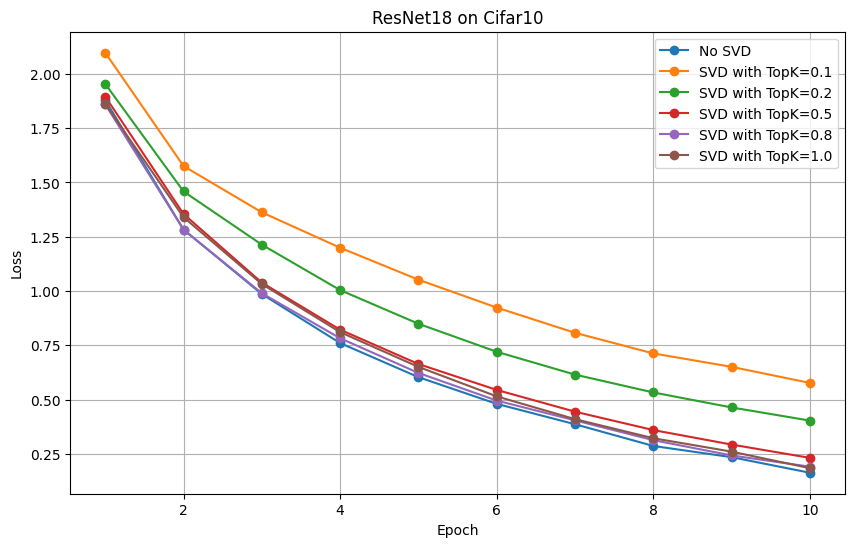

In [4]:
# Plot the average loss per epoch
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(avg_losses_NoSVD) + 1), avg_losses_NoSVD, label='No SVD', marker='o')
plt.plot(range(1, len(avg_losses_k_0_1) + 1), avg_losses_k_0_1, label='SVD with TopK=0.1', marker='o')
plt.plot(range(1, len(avg_losses_k_0_2) + 1), avg_losses_k_0_2, label='SVD with TopK=0.2', marker='o')
plt.plot(range(1, len(avg_losses_k_0_5) + 1), avg_losses_k_0_5, label='SVD with TopK=0.5', marker='o')
plt.plot(range(1, len(avg_losses_k_0_8) + 1), avg_losses_k_0_8, label='SVD with TopK=0.8', marker='o')
plt.plot(range(1, len(avg_losses_k_1_0) + 1), avg_losses_k_1_0, label='SVD with TopK=1.0', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet18 on Cifar10')
plt.legend()
plt.grid(True)
plt.savefig('plots/ResNet18_Cifar10.pdf')
plt.show()

# Singular Value

In [77]:
# Function to load all singular values from saved files
def load_singular_dict(file_path):
    singular_values_dict = {}
    assert os.path.isfile(file_path), f'File {file_path} not found'
    singular_values_dict = torch.load(file_path)
    return singular_values_dict
    
# Function to plot the frequency of singular values
def plot_singular_value_frequencies(singular_values, key=None, epoch=None, batch=None):
    all_singular_values = []
    if(isinstance(singular_values, dict)): # Whole Model
        for _, singular_values in singular_values.items():
            all_singular_values.extend(singular_values.cpu().numpy())
    else: # Each Tile
        all_singular_values = singular_values.cpu().numpy()    
    # Convert list to a NumPy array
    all_singular_values = np.array(all_singular_values)
    
    # Define the magnitude ranges
    bins = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 0]
    bin_labels = ['1e-1', '1e-2', '1e-3', '1e-4', '1e-5', '1e-6', '1e-7', '1e-8']
    
    # Calculate frequencies
    frequencies = [np.sum((all_singular_values < bins[i]) & (all_singular_values >= bins[i+1])) for i in range(len(bins) - 1)]
    
    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(bin_labels, frequencies, width=0.5, align='center')
    plt.yscale('log')
    plt.xlabel('Singular Value Magnitude')
    plt.ylabel('Frequency')
    if key:
        plt.title(f'Frequency of Singular Values at epoch {epoch} batch {batch} for {key}')
    else:
        plt.title(f'Frequency of Singular Valuesat epoch {epoch} batch {batch}')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.savefig(f'plots/Singular_Values_Frequency_epoch{epoch}_batch{batch}.pdf')
    plt.show()


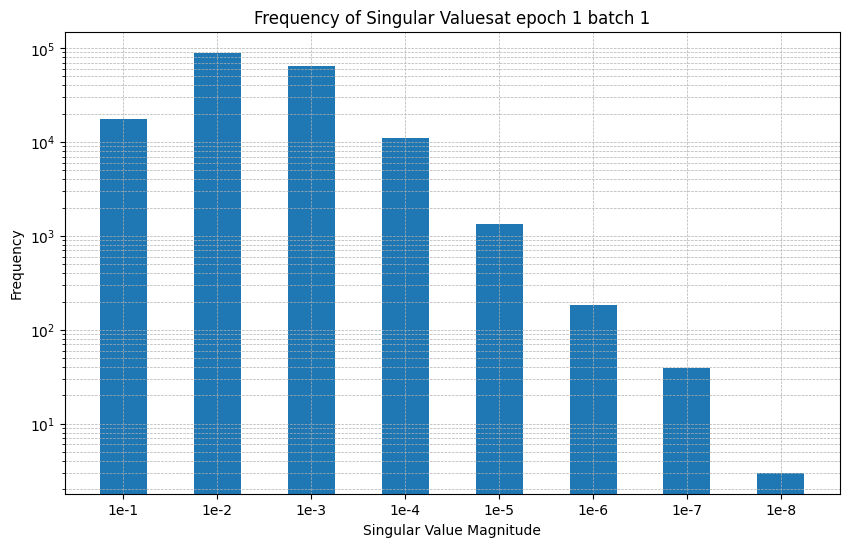

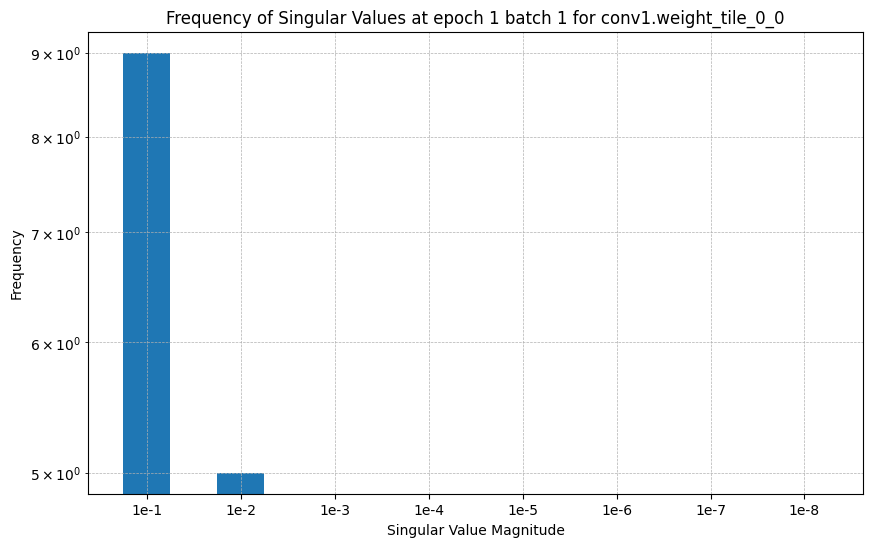

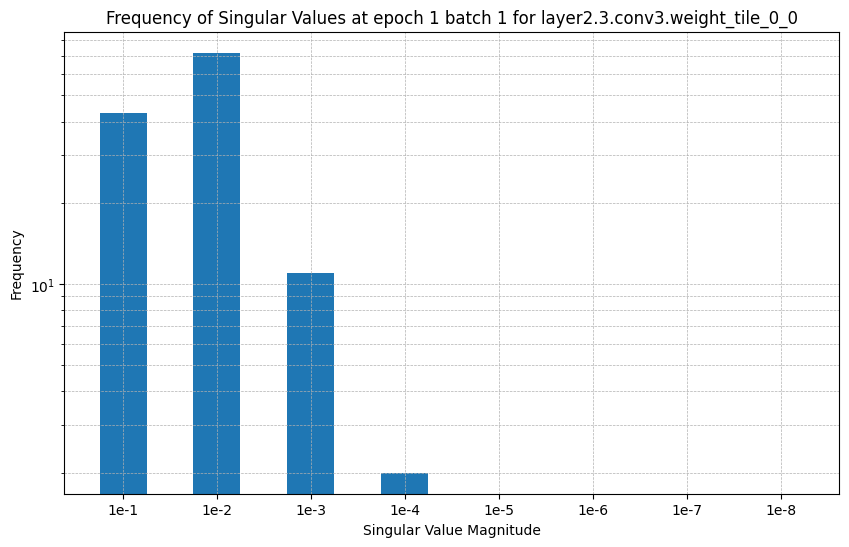

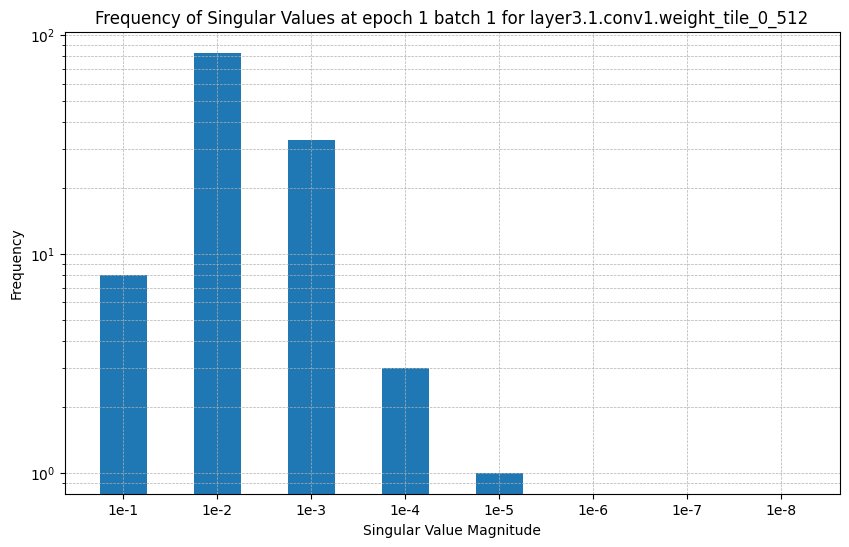

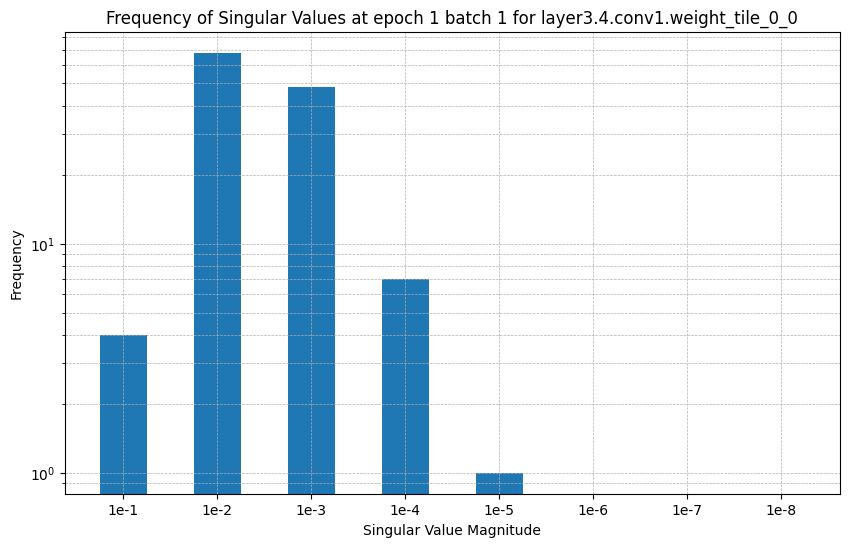

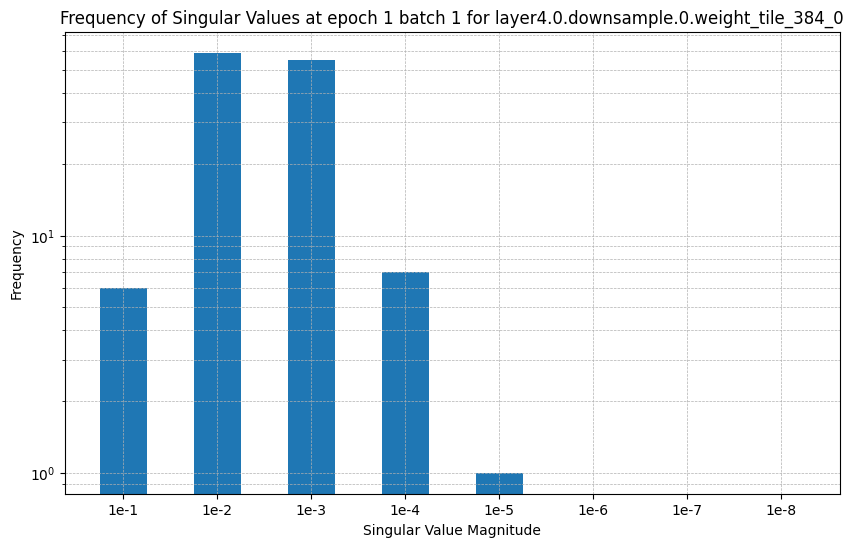

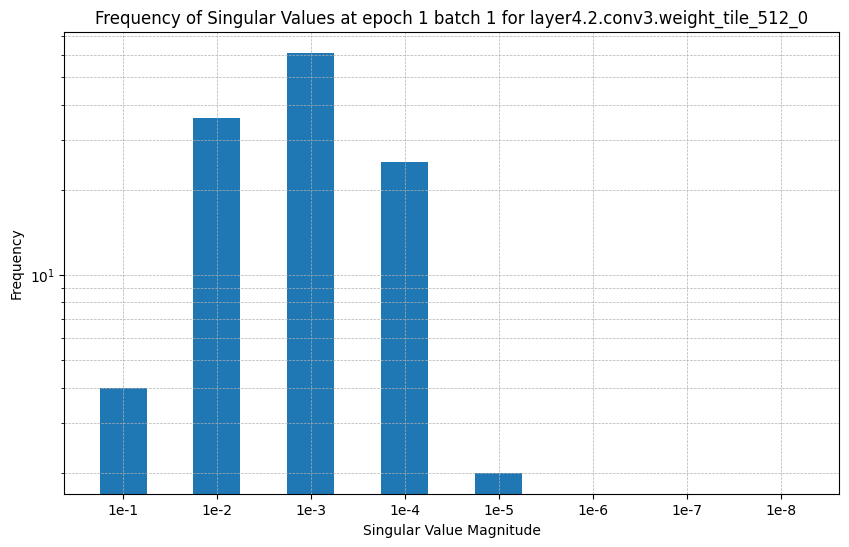

In [78]:
# Path to the folder where singular values are stored
epoch=1
batch=1
file_path = f'./dump/SVD_Tile_Threshold0/gradients_singular_epoch{epoch}_batch_{batch}.pt'
singular_values_dict = load_singular_dict(file_path)# Load and plot the singular values

# Plot whole model
plot_singular_value_frequencies(singular_values_dict,epoch=epoch, batch=batch)

# Plot a tile
count_tile = 0
for key, singular_values in singular_values_dict.items():
    count_tile += 1
    if count_tile not in [1, 100, 200, 400, 800, 1400]:
        continue
    plot_singular_value_frequencies(singular_values, key, epoch=epoch, batch=batch)